In [70]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import dataset from data.csv file
dataset = pd.read_csv('weatherAUS.csv')

#removing NA from MaxTemp variable
dataset = dataset.dropna(subset=["MaxTemp"])
dataset=dataset.reset_index(drop=True)
#including only MaxTemp for training set
training_set = dataset.iloc[len(dataset)-2000:len(dataset)-40,3:4].values
testing_set = dataset.iloc[len(dataset)-40:len(dataset)-10,3:4].values
real_temperature = dataset.iloc[len(dataset)-10:,3:4].values
print(len(training_set),len(testing_set),len(real_temperature))

1960 30 10


In [0]:
#Feature Scaling to normalize temperature in the range 0 to 1
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [0]:
x_train = []
y_train = []
n_future = 10 # next 10 days temperature forecast
n_past = 30 # Past 30 days 
for i in range(0,len(training_set_scaled)-n_past-n_future+1):
    x_train.append(training_set_scaled[i : i + n_past , 0])     
    y_train.append(training_set_scaled[i + n_past : i + n_past + n_future , 0 ])
x_train , y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0] , x_train.shape[1], 1) )


In [0]:
#to build an RNN model for forecasting weather
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

In [75]:

# Fitting RNN to training set using Keras Callbacks. Read Keras callbacks docs for more info.
#creating a sequential model by adding layers sequentially
regressor = Sequential()

#Notes:
# The first layer is a Bidirectional LSTM with 30 memory units
# return_sequence=True means that the last output in the output sequence is returned 
# the input_shape describes the structure of the input
# With Bidirectional LSTM the output layer gets feedback from past(forward)
# as well as future(backward) states simultaneously
# adding 3 hidden layers and an output layer with a 
# linear activation function that outputs 4 days temperature

regressor.add(Bidirectional(LSTM(units=30, return_sequences=True, input_shape = (x_train.shape[1],1) ) ))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units= 30 , return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units= 30 , return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units= 30))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = n_future,activation='linear'))

regressor.compile(optimizer='adam', loss='mean_squared_error',metrics=['acc'])
regressor.fit(x_train, y_train, epochs=500,batch_size=50 )

Epoch 1/500
1921/1921 [==============================] - 11s 6ms/step - loss: 0.1612 - acc: 0.0942
Epoch 2/500
1921/1921 [==============================] - 4s 2ms/step - loss: 0.0465 - acc: 0.0953
Epoch 3/500
1921/1921 [==============================] - 4s 2ms/step - loss: 0.0359 - acc: 0.0994
Epoch 4/500
1921/1921 [==============================] - 4s 2ms/step - loss: 0.0319 - acc: 0.1098
Epoch 5/500
1921/1921 [==============================] - 4s 2ms/step - loss: 0.0309 - acc: 0.0958
Epoch 6/500
1921/1921 [==============================] - 4s 2ms/step - loss: 0.0294 - acc: 0.1005
Epoch 7/500
1921/1921 [==============================] - 4s 2ms/step - loss: 0.0279 - acc: 0.0869
Epoch 8/500
1921/1921 [==============================] - 4s 2ms/step - loss: 0.0254 - acc: 0.1010
Epoch 9/500
1921/1921 [==============================] - 4s 2ms/step - loss: 0.0248 - acc: 0.1088
Epoch 10/500
1921/1921 [==============================] - 4s 2ms/step - loss: 0.0242 - acc: 0.0937
Epoch 11/500
1921/

In [0]:
# Testing
testing = sc.transform(testing_set)
testing = np.array(testing)
testing = np.reshape(testing,(testing.shape[1],testing.shape[0],1))


In [80]:
#Predicting
predicted_temperature = regressor.predict(testing)
predicted_temperature = sc.inverse_transform(predicted_temperature)

predicted_temperature = np.reshape(predicted_temperature,(predicted_temperature.shape[1],predicted_temperature.shape[0]))
print(type(predicted_temperature))
print(real_temperature)

<class 'numpy.ndarray'>
[[22.5]
 [24.3]
 [23.4]
 [20.7]
 [20.6]
 [21.8]
 [23.4]
 [25.3]
 [26.9]
 [27. ]]


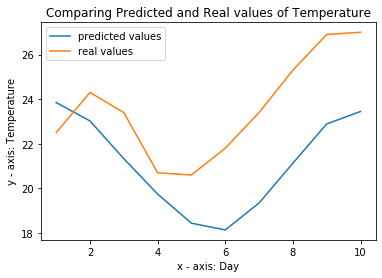

In [81]:
import matplotlib.pyplot as plt
x = [1,2,3,4,5,6,7,8,9,10]
#plotting forecasted values
y = predicted_temperature 
plt.plot(x, y, label = "predicted values")
#plotting real values as measured
y2 = real_temperature
# plotting the line 2 points 
plt.plot(x, y2, label = "real values")
plt.xlabel('x - axis: Day')
plt.ylabel('y - axis: Temperature')
# Set a title of the current axes.
plt.title('Comparing Predicted and Real values of Temperature')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [83]:
from sklearn import metrics
#MAE
print(metrics.mean_absolute_error(real_temperature,predicted_temperature))
#MSE
print(metrics.mean_squared_error(real_temperature,predicted_temperature))
#RMSE
print(np.sqrt(metrics.mean_squared_error(real_temperature,predicted_temperature)))


2.7250645065307615
8.920788288557741
2.986768870963694
